# Nonlinear regression using lmfit combined with using the delta method to estimate confidence intervals and prediction intervals

**An example using a 2-parameter Monod function**

by Greg Pelletier (gjpelletier@gmail.com)

This script uses the python package called lmfit for nonlinear regression. We also include a new function using the delta method, to extend beyond the capabilities of lmfit, to estimate confidence intervals for predicted values, and prediction intervals for new data, using the nonlinear regression fit.

The lmfit package is used to find the best-fit values and the variance-covariance matrix of the model parameters. The user may specify any expression for the nonlinear regression model. The lmfit package is described at the following link:

https://lmfit.github.io//lmfit-py/index.html

In this example we use a 2-parameter Monod function (Michaelis-Menten) to fit an enzymology data set (https://rforbiochemists.blogspot.com/2015/05/plotting-and-fitting-enzymology-data.html)

To estimate the confidence intervals and prediction intervals, we use a new python function that applies the delta method. The delta method is described in detail in Section 5.1 of this online lecture:

https://jchiquet.github.io/MAP566/docs/regression/map566-lecture-nonlinear-regression.html#the-delta-method

___

First we need to install lmfit if it is not already installed:


In [1]:
pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 9.6 MB/s eta 0:00:00


Next we import the necessary python packages:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
from numpy import exp, linspace, sin
import lmfit as fit
from lmfit.models import ExpressionModel

Next we will data from an enzyme study, where x= substrate (mmol), and y= velocity (nmmol/sec)

In [3]:
x = np.array([0,1,2,5,8,12,30,50])
y = np.array([0,11.1,25.4,44.8,54.5,58.2,72,60.1])

We will use the ExpressionModel function of lmfit to specify the 2-parameter Monod function that we want to fit to our data:

In [4]:
mod = ExpressionModel('(Vm * x)/(Km + x)')

The next step is to define the initial values for the parameters Vm and Km of the model function

In [5]:
Vm_init = 60
Km_init = 5

Now we can build the set of the initial parameter values as follows:


In [6]:
pars = fit.Parameters()
pars['Vm'] = fit.Parameter(name='Vm', value=Vm_init, min=-np.inf, max=np.inf)
pars['Km'] = fit.Parameter(name='Km', value=Km_init, min=-np.inf, max=np.inf)

Now we are ready to run lmfit to find the best-fit parameters and variance covariance matrix of the model. The output results will be stored in "out"

In [7]:
out = mod.fit(y, pars, x=x)

We can print out a summary of the model fit results as follows:

In [8]:
print(out.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 8
    # variables        = 2
    chi-square         = 156.447238
    reduced chi-square = 26.0745396
    Akaike info crit   = 27.7862182
    Bayesian info crit = 27.9451013
    R-squared          = 0.96625571
[[Variables]]
    Vm:  73.2614087 +/- 4.58241018 (6.25%) (init = 60)
    Km:  3.43716914 +/- 0.81732291 (23.78%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(Vm, Km) = +0.7906


The best-fit values of the model parameters can now be extracted into a numpy array that we named "param" from the lmfit results as follows:

In [9]:
param=np.array(out.params)
param

array([73.26140869,  3.43716914])

The variance-covariance matrix of the model parameters can be extracted into a numpy array that we name "COVB" as follows:

In [10]:
COVB = out.covar
COVB

array([[20.99848301,  2.96093853],
       [ 2.96093853,  0.66801673]])

Now we have almost everything we need in order to estimate the confidence intervals and prediction intervals of the model. Before doing that, we need to define a function that will apply the delta method as follows:

In [11]:
def delta_method(COVB,param,x_new,f,x,y,alpha):
    # - - -
    # Function to calculate the confidence interval and prediction interval
    # for any user-defined regression function using the delta-method
    # as described in Sec 5.1 of the following online statistics lecture:
    # https://jchiquet.github.io/MAP566/docs/regression/map566-lecture-nonlinear-regression.html
    #
    # Greg Pelletier (gjpelletier@gmail.com)
    # - - -
    # INPUT
    # COVB = variance-covariance matrix of the model parameters (e.g. out.covar from lmfit)
    # param = best-fit parameters of the regression function
    # x_new = new x values to evaluate new predicted y_new values (e.g. x_new=linspace(min(x),max(x),100)
    # f = user-defined regression lambda function to predict y given inputs if param and x values (e.g. observed x or x_new)
    # 	For example, if using the 3-parameter nonlinear regression exponential threshold function, then
    # 	f = lambda param,xval : param[0] + param[1] * exp(param[2] * xval)
    # x = observed x
    # y = observed y
    # alpha = significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    # - - -
    # OUTPUT
    # dict = dictionary of output varlables with the following keys:
    #        'param': best-fit parameter values used as input
    #        'COVB': variance-covariance matrix used as input
    #        'fstr': string of the input lambda function of the regression model
    #        'alpha': input significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    #        'x': observed x values used as input
    #        'y': observed y values used as input
    #        'yhat': predicted y at observed x values
    #        'x_new': new x-values used as input to evaluate unew predicted y_new values
    #        'y_new': new predicted y_new values at new x_new values
    #        'lwr_conf': lower confidence interval for each value in x_new
    #        'upr_conf': upper confidence interval for each value in x_new
    #        'lwr_pred': lower prediction interval for each value in x_new
    #        'upr_pred': upper prediction interval for each value in x_new
    #        'G_new': variance due to each paramter at x_new
    #        'GS_new': variance due to all parameters combined at x_new
    #        'SST': Sum of Squares Total
    #        'SSR': Sum of Squares Regression
    #        'SSE': Sum of Squares Error
    #        'MSR': Mean Square Regression
    #        'MSE': Mean Square Error of the residuals
    #        'syx': standard error of the estimate
    #        'nobs': number of observations
    #        'nparam': number of parameters
    #        'df': degrees of freedom = nobs-nparam
    #        'qt': 2-tailed t-statistic at alpha
    #        'Fstat': F-statistic = MSR/MSE
    #        'dfn': degrees of freedom for the numerator of the F-test = nparam-1
    #        'dfd': degrees of freedom for the denominator of the F-test = nobs-nparam
    #        'pvalue': signficance level of the regression from the probability of the F-test
    #        'rsquared': r-squared = SSR/SST
    #        'adj_rsquared': adjusted squared
    import numpy as np
    from scipy import stats
    import inspect
    # - - -
    # calculate predicted y_new at each x_new
    y_new = f(param,x_new)
    # calculate derivative gradients at x_new (change in f(x_new) per change in each param using +1ppb change in each param)
    grad_new = np.empty(shape=(np.size(x_new),np.size(param)))
    h = 1e-8       # h= small change for each param to balance truncation error and rounding error of the gradient
    for i in range(np.size(param)):
        # make a copy of param
        param2 = np.copy(param)
        # gradient forward
        param2[i] = (1+h) * param[i]
        y_new2 = f(param2, x_new)
        dy = y_new2 - y_new
        dparam = param2[i] - param[i]
        grad_up = dy / dparam
        # gradient backward
        param2[i] = (1-h) * param[i]
        y_new2 = f(param2, x_new)
        dy = y_new2 - y_new
        dparam = param2[i] - param[i]
        grad_dn = dy / dparam
        # centered gradient is the average gradient forward and backward
        grad_new[:,i] = (grad_up + grad_dn) / 2
    # calculate variance in y_new due to each parameter and for all parameters combined
    G_new = np.matmul(grad_new,COVB) * grad_new         # variance in y_new due to each param at each x_new
    GS_new = np.sum(G_new,axis=1)                       # total variance from all param values at each x_new
    # - - -
    # # lwr_conf and upr_conf are confidence intervals of the best-fit curve
    nobs = np.size(x)
    nparam = np.size(param)
    df = nobs - nparam
    qt = stats.t.ppf(1-alpha/2, df)
    delta_f = np.sqrt(GS_new) * qt
    lwr_conf = y_new - delta_f
    upr_conf = y_new + delta_f
    # - - -
    # # lwr_pred and upr_pred are prediction intervals of new observations
    yhat = f(param,x)
    SSE = np.sum((y-yhat) ** 2)                 # sum of squares (residual error)
    MSE = SSE / df                              # mean square (residual error)
    syx = np.sqrt(MSE)                          # std error of the estimate
    delta_y = np.sqrt(GS_new + MSE) * qt
    lwr_pred = y_new - delta_y
    upr_pred = y_new + delta_y
    # - - -
    # optional additional outputs of regression statistics
    SST = np.sum(y **2) - np.sum(y) **2 / nobs  # sum of squares (total)
    SSR = SST - SSE                             # sum of squares (regression model)
    MSR = SSR / (np.size(param)-1)              # mean square (regression model)
    Fstat = MSR / MSE           # F statistic
    dfn = np.size(param) - 1    # df numerator = degrees of freedom for model = number of model parameters - 1
    dfd = df                    # df denomenator = degrees of freedom of the residual = df = nobs - nparam
    pvalue = 1-stats.f.cdf(Fstat, dfn, dfd)      # p-value of F test statistic
    rsquared = SSR / SST                                                        # ordinary rsquared
    adj_rsquared = 1-(1-rsquared)*(np.size(x)-1)/(np.size(x)-np.size(param)-1)  # adjusted rsquared
    # - - -
    # make a string of the lambda function f to save in the output dictionary
    fstr = str(inspect.getsourcelines(f)[0])
    # make the dictionary of output variables from the delta-method
    dict = {
            'param': param,
            'COVB': COVB,
            'fstr': fstr,
            'alpha': alpha,
            'x': x,
            'y': y,
            'yhat': yhat,
            'x_new': x_new,
            'y_new': y_new,
            'lwr_conf': lwr_conf,
            'upr_conf': upr_conf,
            'lwr_pred': lwr_pred,
            'upr_pred': upr_pred,
            'G_new': G_new,
            'GS_new': GS_new,
            'SST': SST,
            'SSR': SSR,
            'SSE': SSE,
            'MSR': MSR,
            'MSE': MSE,
            'syx': syx,
            'nobs': nobs,
            'nparam': nparam,
            'df': df,
            'qt': qt,
            'Fstat': Fstat,
            'dfn': dfn,
            'dfd': dfd,
            'pvalue': pvalue,
            'rsquared': rsquared,
            'adj_rsquared': adj_rsquared
            }

    return dict

Before using the delta_method function, we first need to make a few more inputs for it as follows (NOTE: make sure that the lambda function f below matches the ExpressionModel function defined earlier):

In [12]:
# model lambda function to use for any param or xval
f = lambda param,xval : (param[0] * xval) / (param[1] + xval)

# evenly spaced new observations that extend from below min(x) to above max(x)
x_new = linspace(0, 50, 100)

# probability level for the prediction limits (e.g. alpha=0.05 for 95% prediction limits and 95% confidence limits)
alpha=0.05

Now we are ready to use the delta_method function to get its outut dictionary, which includes the predicted y_new values, and the 95% prediction limits (lwr_pred and upr_pred), and 95% confidence limits (lwr_conf and upr_conf), at alpha=0.05 for new observations (x_new), as well as other regression statistics

In [13]:
d = delta_method(COVB,param,x_new,f,x,y,alpha)

Now we can plot the results of lmfit, combined with the results of the delta_method function to estimate the prediction intervals and confidence intervals.

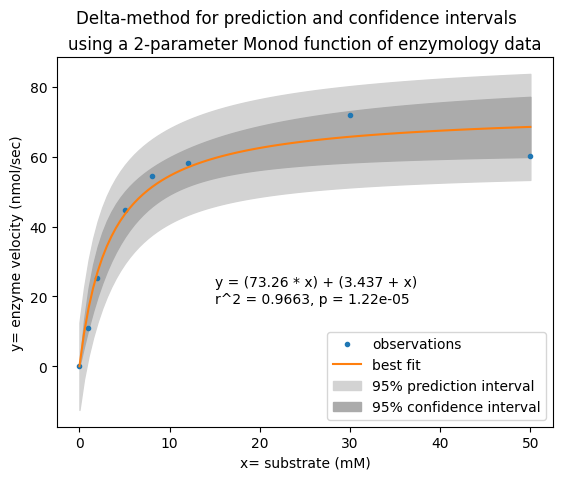

In [14]:
# extract the output values we need for the plot from the delta-method output dictionary
y_new = d['y_new']
lwr_conf = d['lwr_conf']
upr_conf = d['upr_conf']
lwr_pred = d['lwr_pred']
upr_pred = d['upr_pred']
rsquared = d['rsquared']
pvalue = d['pvalue']

# make string values of fit stats and eqn for the plot labels
pstr = '%.2e' %pvalue
rsqstr = '%.4f' %rsquared
b1str = '%.2f' %param[0]
b2str = '%.3f' %param[1]
eqnstr = 'y = (' + b1str + ' * x) + (' + b2str + ' + x)'

# generate the plot
plt.figure()
plt.plot(x, y, '.', label='observations')
# observations
plt.plot(x_new, y_new, '-', label='best fit')
# 95% prediction limits using the delta method
plt.fill_between(x_new, lwr_pred, upr_pred,color="#d3d3d3", label='95% prediction interval')
# 95% confidence limits using the delta method
plt.fill_between(x_new, lwr_conf, upr_conf,color="#ABABAB", label='95% confidence interval')
plt.legend(loc='lower right')
plt.suptitle('Delta-method for prediction and confidence intervals')
plt.title('using a 2-parameter Monod function of enzymology data')
plt.xlabel('x= substrate (mM)')
plt.ylabel('y= enzyme velocity (nmol/sec)')
plt.text(15, 23, eqnstr, fontsize = 10)
plt.text(15, 18, 'r^2 = '+rsqstr+', p = '+pstr, fontsize = 10)
plt.ticklabel_format(style='plain', axis='y')
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

More regression statistics calculated using the delta method:

In [15]:
# extract the output values we need for the regression stats
pvalue = d['pvalue']
rsquared = d['rsquared']
adj_rsquared = d['adj_rsquared']
qt = d['qt']
MSE = d['MSE']
syx = d['syx']
df = d['df']

# print the regression stats
print('p-value of the regression F test = ' + '%.2e' %pvalue)
print('rsquared = ' + '%.4f' %rsquared)
print('adjusted rsquared = ' + '%.4f' %adj_rsquared)
print('2-tailed t-statistic at alpha ' + '%.2f' %alpha + ' used for confidence/prediction intervals = ' + '%.3f' %qt)
print('Mean Square Error (MSE) of the residuals = ' + '%.3e' %MSE)
print('standard error of the regression = ' + '%.3e' %syx)
print('degrees of freedom (number of observations - number of parameters) = ' + '%.0f' %df)

p-value of the regression F test = 1.22e-05
rsquared = 0.9663
adjusted rsquared = 0.9528
2-tailed t-statistic at alpha 0.05 used for confidence/prediction intervals = 2.447
Mean Square Error (MSE) of the residuals = 2.607e+01
standard error of the regression = 5.106e+00
degrees of freedom (number of observations - number of parameters) = 6
